<a href="https://colab.research.google.com/github/enti1701aaa/Final-Team1/blob/main/Finalproject_1%ED%8C%80%EC%95%88%EC%A7%80%EC%98%81_%EA%B0%80%EC%84%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
# CSV 불러오기
df = pd.read_csv("/content/S-team_250930-final.csv")

#[가설] 스팀 세일 이벤트가 유저의 행동에 어떤 영향을 주는가?
- 원래는 매출 효과를 보고 싶었지만, 데이터에 매출이 없어서

→ **리뷰 수, 추천률**을 매출 대리 지표로 사용하기로 함.

##“세일 종류(대형 이벤트 참여 vs 개별 게임 세일)에 따라 추천률 상승 폭이 다르다.”


###개요

1. 사용 컬럼
    - sale_context (none: 할인 미참여, game_only: 게임 단독 할인, both: 대형 이벤트 참여)
    - voted_up(추천률)

2. 유의성 검정: 집계형 GLM(Binomial)
    - 반응변수: positive_rate(=집계 평균 비율)

    - 가중치: 각 집단의 표본수 n을 freq_weights로 사용 → 개별 로지스틱과 동일한 정보를 집계형으로 안정적으로 추정.

    - 설명변수: C(sale_context_norm) (기준: none)

    - 출력: 회귀 요약표, 계수→오즈비(OR), 95% CI, p-value.
3. 기대: both(스팀 대형세일 참여 + 자체 세일) > game_only > none.

###코드


=== Uplift by sale_context ===
  sale_context_norm  positive_rate     pos       n
0              none         0.8783  164797  187640
1         game_only         0.9351     317     339
2              both         0.9456     278     294


/tmp/ipython-input-1671442830.py:51: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = (sub.groupby("sale_context_norm")["voted_up_bin"]


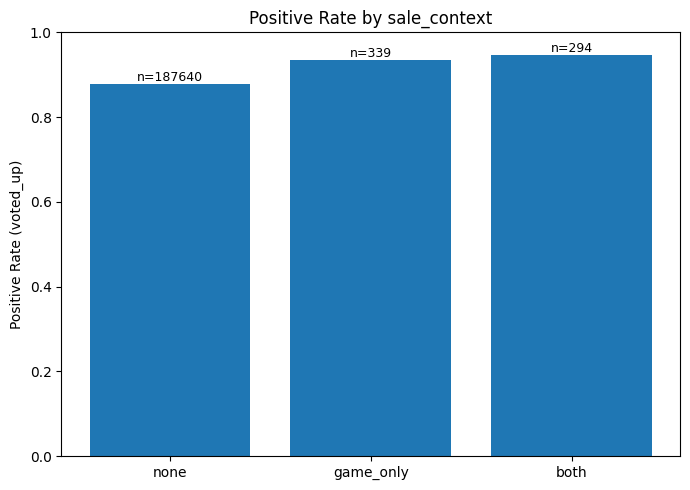

/usr/local/lib/python3.12/dist-packages/statsmodels/regression/_tools.py:121: RuntimeWarning: divide by zero encountered in scalar divide
  scale = np.dot(wresid, wresid) / df_resid



=== GLM(Binomial, aggregated) summary ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:          positive_rate   No. Observations:                    3
Model:                            GLM   Df Residuals:                   188270
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -49844.
Date:                Tue, 30 Sep 2025   Deviance:                   6.5281e-14
Time:                        04:02:21   Pearson chi2:                 3.46e-28
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9999
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf

df = pd.read_csv("/content/S-team_250930-final.csv")

# 0) 전처리

# voted_up -> voted_up_bin 정규화
def to_binary(x):
    if x is None:
        return np.nan
    if isinstance(x, (int, float)):
        if x in (0, 1):
            return int(x)
        return int(bool(x))
    s = str(x).strip().lower()
    if s in {"1","true","t","yes","y"}: return 1
    if s in {"0","false","f","no","n"}: return 0
    return np.nan

df["voted_up_bin"] = df["voted_up"].apply(to_binary)

# sale_context 정규화 (예상값: none / game_only / both)
def norm_sc(s):
    s = str(s).strip().lower() if pd.notna(s) else "none"
    # 표기 변형 흡수
    s = s.replace("-", "_").replace(" ", "_")
    if s in {"", "nan", "none"}:
        return "none"
    if s in {"game_only", "gameonly", "only_game"}:
        return "game_only"
    if s in {"both"}:
        return "both"
    # 기타값은 보수적으로 none 처리
    return s if s in {"none","game_only","both"} else "none"

df["sale_context_norm"] = df["sale_context"].map(norm_sc) if "sale_context" in df.columns else "none"
# 카테고리 순서 지정
cat_type = pd.api.types.CategoricalDtype(categories=["none","game_only","both"], ordered=True)
df["sale_context_norm"] = df["sale_context_norm"].astype(cat_type)

# 분석용 서브셋
sub = df.dropna(subset=["voted_up_bin","sale_context_norm"]).copy()


# 1) Uplift (비교표 + 시각화)

agg = (sub.groupby("sale_context_norm")["voted_up_bin"]
          .agg(["mean","sum","count"])
          .rename(columns={"mean":"positive_rate","sum":"pos","count":"n"})
          .reset_index())

print("\n=== Uplift by sale_context ===")
print(agg)

# Bar chart: positive rate by sale_context (표본수 라벨)
plt.figure(figsize=(7,5))
x = np.arange(len(agg))
plt.bar(x, agg["positive_rate"])
plt.xticks(x, agg["sale_context_norm"])
for i,(rate,n) in enumerate(zip(agg["positive_rate"], agg["n"])):
    plt.text(i, rate, f"n={n}", ha="center", va="bottom", fontsize=9)
plt.ylim(0, 1.0)
plt.ylabel("Positive Rate (voted_up)")
plt.title("Positive Rate by sale_context")
plt.tight_layout()
plt.show()


# 2) 집계형 GLM (Binomial) — 유의성 검정
#    endog = 비율, weights = 시행수
glm_agg = smf.glm(
    formula="positive_rate ~ C(sale_context_norm)",
    data=agg,
    family=sm.families.Binomial(),
    freq_weights=agg["n"]
).fit()

print("\n=== GLM(Binomial, aggregated) summary ===")
print(glm_agg.summary())

# OR / 95% CI 정리 (baseline: sale_context=none)
params = glm_agg.params
conf   = glm_agg.conf_int()
conf.columns = ["ci_low","ci_high"]
or_tbl = pd.DataFrame({
    "coef": params,
    "OR": np.exp(params),
    "p_value": glm_agg.pvalues,
    "OR_ci_low": np.exp(conf["ci_low"]),
    "OR_ci_high": np.exp(conf["ci_high"]),
}).round(4)
print("\n=== Odds Ratios (baseline: none) ===")
print(or_tbl)


# 3) 쌍체 비교 (Wald tests)

print("\n=== Wald tests (pairwise) ===")

# game_only vs none (더미 자체가 none 대비 차이)
print("H0: game_only == none")
print(glm_agg.t_test("C(sale_context_norm)[T.game_only] = 0"))

# both vs none
print("\nH0: both == none")
print(glm_agg.t_test("C(sale_context_norm)[T.both] = 0"))

# both vs game_only (두 계수 차이)
print("\nH0: both == game_only")
print(glm_agg.t_test("C(sale_context_norm)[T.both] - C(sale_context_norm)[T.game_only] = 0"))


###해석

1️⃣ 단순 집계 결과 (Uplift by sale_context)
- none       : 0.878 (n=187,640)
- game_only  : 0.935 (n=339)
- both       : 0.946 (n=294)

👉 세일이 있을수록 추천률이 눈에 띄게 높아짐.
단, game_only, both 그룹의 표본수는 매우 적음(수백 건 수준) → 추정치는 불안정할 수 있음.

2️⃣ GLM(Binomial, aggregated) 결과
회귀 계수/오즈비 (baseline: none)

- Intercept (none 그룹):

    - coef=1.9761 → OR≈7.21

    - none 상황에서 **추천될 오즈(찬성/반대 비율)**가 약 7.2배.

    - 확률로 환산하면 7.2/(1+7.2)=87.8% → 집계 결과와 일치.

- game_only:

    - coef=0.6918 → OR≈2.00 (p=0.0017, 유의)

    - 즉, 게임 세일일 때 추천 오즈가 none 대비 약 2배.

    - 추천률 자체도 약 **93.5%**로 증가.

- both:

    - coef=0.8790 → OR≈2.41 (p=0.0006, 유의)

    - 이벤트+게임 동시 세일일 때 추천 오즈가 none 대비 약 2.4배.

    - 추천률은 약 **94.6%**로 증가.

3️⃣ 쌍체 비교 (Wald tests)

- game_only vs none

    - z=3.136, p=0.002 → 유의한 차이 있음.

    - 게임 세일이 없을 때보다 추천률이 확실히 올라감.

- both vs none

    - z=3.418, p=0.001 → 유의한 차이 있음.

    - 동시 세일 역시 세일 없음보다 추천률이 높음.

- both vs game_only

    - z=0.553, p=0.581 → 유의하지 않음.

    - 즉, 게임 단독 세일과 동시 세일은 통계적으로 큰 차이가 없다.

📌 최종 해석

- 세일 없음 대비 세일이 있을 때 추천률은 유의하게 증가한다.

    - none → 약 88%

    - game_only → 약 94% (OR≈2.0, p=0.002)

    - both → 약 95% (OR≈2.4, p=0.001)

- 게임 단독 세일과 동시 세일 간에는 유의한 차이가 없다 (p=0.58).

따라서 “세일이 존재하는 것 자체”가 긍정 리뷰율을 끌어올리는 핵심 요인이고,

세일 형태(game_only vs both)는 큰 차이를 만들지 않는 것으로 보인다.

##세일 이벤트는 게임의 첫 세일일을 기점으로 리뷰량을 단기적으로 유의하게 증가시킨다.



###개요

**1. 사용컬럼**
- appid, timestamp_created, on_game_sale, sale_context

- 파생변수생성
    - rev_count: 게임×일자별 리뷰 수

    - sale_day: 게임×일자별 세일 여부

    - first_sale_day: 각 게임의 첫 세일 발생일

    - event_time: 첫 세일일 대비 상대일수 (t=-30 … +30)

**2. 검정방법**
- 설계: 이벤트 스터디(Event Study)

    - 첫 세일일 기준으로 ±30일 균등 패널 생성

    - t=-1일을 기준으로 이벤트 타임 더미 회귀

- 모형: 패널 Poisson 회귀 (선택 시 Negative Binomial)

- 고정효과(TWFE):

    - 게임 고정효과(C(appid)) → 게임별 인기도 차이 제거

    - 시간 고정효과(C(week_key) or C(day)) → 공통 시기 효과 제거

- 표준오차:

    - 기본: 게임 단위 클러스터(clustered by appid)

    - 실패 시: HC1 robust → ridge regularization 폴백

**3. 기대/목표**
- 목표
    - 세일 이벤트가 발생했을 때, 리뷰 수가 세일 전날 대비 몇 배 증가/감소하는지(IRR)와 그 패턴의 지속성

- 결과 해석:

    - 계수 지수화(exp(coef)) = IRR (Incident Rate Ratio)

    - IRR > 1 → 리뷰 수 증가, IRR < 1 → 감소

    - IRR 곡선으로 세일 직후 반응 크기와 지속 기간 파악 가능

###EDA

[INFO] 분석 대상 게임 수: 200, 세일 경험 게임 수: 200

=== TWFE Poisson (Daily/Weekly FE, clustered by appid) ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:              rev_count   No. Observations:                12200
Model:                            GLM   Df Residuals:                    11692
Model Family:                 Poisson   Df Model:                          507
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2573.6
Date:                Tue, 30 Sep 2025   Deviance:                       3215.0
Time:                        04:03:26   Pearson chi2:                 8.09e+03
No. Iterations:                    24   Pseudo R-squ. (CS):             0.2097
Covariance Type:              cluster                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
-----

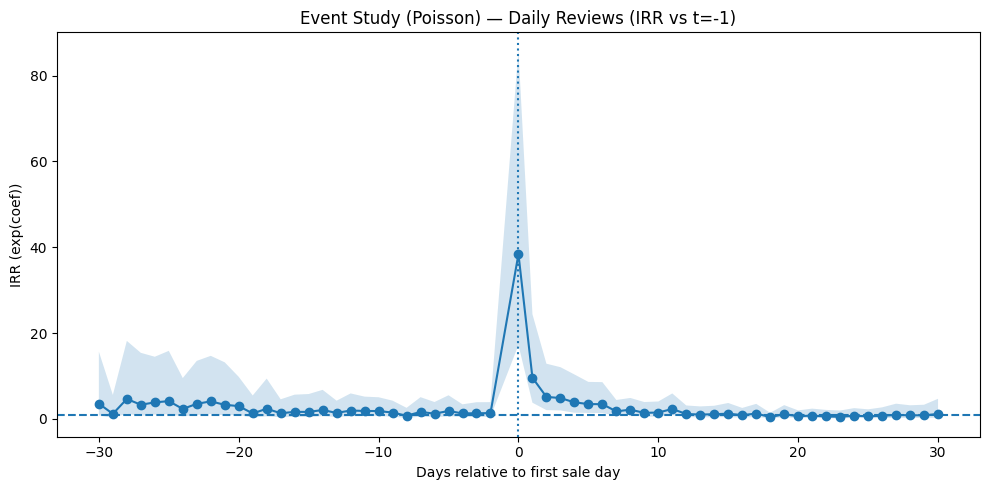

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

CSV_PATH    = "/content/S-team_250930-final.csv"
TOP_APPS    = 200      # 세일 경험 상위 게임 수
WINDOW_D    = 30       # 이벤트 윈도우(일): t = -WINDOW_D ... +WINDOW_D
USE_NB      = False    # True→Negative Binomial, False→Poisson
USE_WEEK_FE = False    # True→주차 FE, False→캘린더 일자 FE
SHOW_TABLE  = True

# 유틸 함수
def to_binary(x):
    if pd.isna(x): return np.nan
    if isinstance(x, (int, float)): return int(x != 0)
    s = str(x).strip().lower()
    if s in {"1","true","t","yes","y"}: return 1
    if s in {"0","false","f","no","n"}: return 0
    return np.nan

def parse_mixed_timestamp(s):
    # epoch초 우선 → 실패 시 ISO 문자열(UTC)
    num    = pd.to_numeric(s, errors="coerce")
    dt_num = pd.to_datetime(num, unit="s", utc=True, errors="coerce")
    dt_str = pd.to_datetime(s, utc=True, errors="coerce")
    return dt_num.fillna(dt_str)

def norm_sc(x):
    if pd.isna(x): return "none"
    s = str(x).strip().lower().replace("-", "_").replace(" ", "_")
    if s in {"", "nan"}: s = "none"
    if s in {"gameonly", "only_game"}: s = "game_only"
    if s not in {"none", "game_only", "event_only", "both"}:
        s = "none"
    return s

def safe_et_name(k: int) -> str:
    return f"d_m{abs(k)}" if k < 0 else f"d_p{k}"

def parse_et_name(name: str) -> int:
    if name.startswith("d_m"): return -int(name[3:])
    if name.startswith("d_p"): return  int(name[3:])
    raise ValueError(name)

# 전처리
df = pd.read_csv(CSV_PATH, low_memory=False)

need_cols = {"appid", "timestamp_created", "on_game_sale", "sale_context"}
missing = [c for c in need_cols if c not in df.columns]
if missing:
    raise ValueError(f"필수 컬럼 누락: {missing}")

df["dt"]    = parse_mixed_timestamp(df["timestamp_created"])
df          = df.dropna(subset=["appid", "dt"]).copy()
df["appid"] = df["appid"].astype(str)
df["day"]   = pd.to_datetime(df["dt"]).dt.floor("D")        # timestamp_created -> day로 정규화

df["sale_context_norm"] = df["sale_context"].map(norm_sc)
df["on_sale"] = df["on_game_sale"].apply(to_binary).fillna(0).astype(int)   # sale_context_norm과 on_sale을 이진 변수로 변환.

df["sale_flag"] = ((df["on_sale"] == 1) | (df["sale_context_norm"].isin(["game_only", "both"]))).astype(int)    # 세일 경험 게임만 선별
sale_games = df.loc[df["sale_flag"] == 1, "appid"].dropna().unique().tolist()
if not sale_games:
    raise RuntimeError("세일 경험 게임이 없습니다. sale_context/on_game_sale를 확인하세요.")

# 세일 경험 게임 중 리뷰 많은 TOP_APPS
vc = df["appid"].value_counts()
top_sale_games = vc.loc[vc.index.isin(sale_games)].head(TOP_APPS).index.tolist()
sub = df[df["appid"].isin(top_sale_games)].copy()

# 게임×일 패널 생성
sub["sale_flag_row"] = ((sub["on_sale"] == 1) | (sub["sale_context_norm"].isin(["game_only", "both"]))).astype(int)
cnt_by_day  = sub.groupby(["appid", "day"]).size().rename("rev_count").reset_index()
sale_by_day = sub.groupby(["appid", "day"])["sale_flag_row"].max().rename("sale_day").reset_index()

panel = cnt_by_day.merge(sale_by_day, on=["appid", "day"], how="left").fillna({"sale_day": 0})
panel["rev_count"] = panel["rev_count"].astype(int)
panel["sale_day"]  = panel["sale_day"].astype(int)

# 첫 세일일 산출
first_sale = (panel.loc[panel["sale_day"] == 1, ["appid", "day"]]
              .groupby("appid", as_index=False)["day"].min()
              .rename(columns={"day": "first_sale_day"}))
panel = panel.merge(first_sale, on="appid", how="left")

treated = panel.dropna(subset=["first_sale_day"])[["appid", "first_sale_day"]].drop_duplicates()
if treated.empty:
    raise RuntimeError("선별된 TOP_APPS 중 세일 경험 게임이 없습니다. TOP_APPS를 늘리거나 조건을 확인하세요.")

print(f"[INFO] 분석 대상 게임 수: {len(top_sale_games)}, 세일 경험 게임 수: {treated['appid'].nunique()}")

# 윈도우 내 균등 패널 생성
grids = []
for app, fs in treated.itertuples(index=False):
    days = pd.date_range(fs - pd.Timedelta(days=WINDOW_D), fs + pd.Timedelta(days=WINDOW_D), freq="D")
    grids.append(pd.DataFrame({"appid": app, "day": days, "first_sale_day": fs}))
grid = pd.concat(grids, ignore_index=True)

panel2 = grid.merge(panel, on=["appid", "day", "first_sale_day"], how="left")
panel2["rev_count"] = pd.to_numeric(panel2["rev_count"], errors="coerce").fillna(0).astype(int)
panel2["sale_day"]  = pd.to_numeric(panel2["sale_day"],  errors="coerce").fillna(0).astype(int)
panel2["event_time"] = (panel2["day"] - panel2["first_sale_day"]).dt.days

# 이벤트 더미 변수 생성
base_k = -1
et_cols = []
for k in range(-WINDOW_D, WINDOW_D + 1):
    if k == base_k:
        continue
    col = safe_et_name(k)
    panel2[col] = (panel2["event_time"] == k).astype(int)
    et_cols.append(col)

# 회귀 입력 안전 전처리 + 적합
# 0) FE 축소: '주차' 고정효과 권장 (일자FE는 차원 폭발로 불안정)
panel2["week_key"] = panel2["day"].dt.tz_localize(None).dt.to_period("W").astype(str)
fe_col = "week_key"

# 희소 이벤트 더미 정리: 너무 적게 관측된 t는 제거
# 최소 등장 건수(min_count)와 총합(min_sum)을 동시에 조건으로
min_count = 20   # 관측 행 수 최소
min_sum   = 20   # 해당 더미가 '1'인 총합 최소
et_active = []
for c in et_cols:
    col_sum   = panel2[c].sum(skipna=True)
    col_count = panel2[c].count()  # NaN 제외 행 수
    if (col_sum >= min_sum) and (col_count >= min_count):
        et_active.append(c)
dropped = sorted(set(et_cols) - set(et_active))
if dropped:
    print(f"[WARN] 희소 이벤트 더미 제거: {dropped}")

# 모델 데이터프레임 구성
model_cols = ["rev_count", "appid", fe_col] + et_active
model_df = panel2[model_cols].copy()

# 타입/결측/무한대 정리
model_df["rev_count"] = pd.to_numeric(model_df["rev_count"], errors="coerce").fillna(0).astype(int)
model_df["appid"]     = model_df["appid"].astype(str)
model_df[fe_col]      = model_df[fe_col].astype(str)
model_df = model_df.replace([np.inf, -np.inf], np.nan).dropna()

# 완전 상수(전부 0) 이벤트 더미 최종 제거
et_active = [c for c in et_active if model_df[c].sum() > 0]
if not et_active:
    raise RuntimeError("유효한 이벤트 더미가 없습니다. WINDOW_D/TOP_APPS를 조정하세요.")

# 수식/패밀리
rhs = " + ".join(et_active) + f" + C(appid) + C({fe_col})"
formula = f"rev_count ~ {rhs}"
family = sm.families.NegativeBinomial() if USE_NB else sm.families.Poisson()

# 적합 (3단계 폴백)
fit = None
try:
    # (A) 클러스터 SE (선호)
    fit = smf.glm(formula=formula, data=model_df, family=family)\
            .fit(cov_type="cluster", cov_kwds={"groups": model_df["appid"]})
except Exception as e1:
    print(f"[WARN] cluster SE 실패 → HC1로 폴백: {e1}")
    try:
        # (B) 강건 HC1
        fit = smf.glm(formula=formula, data=model_df, family=family)\
                .fit(cov_type="HC1")
    except Exception as e2:
        print(f"[WARN] HC1도 실패 → L2 ridge로 폴백(표준오차 없음): {e2}")
        # (C) L2 정규화 적합 (SE 미제공)
        # 참고: L1_wt=0.0 → L2 ridge, alpha는 크면 수축↑
        fit = sm.GLM.from_formula(formula, data=model_df, family=family)\
                    .fit_regularized(alpha=1e-4, L1_wt=0.0, maxiter=1000)

# 결과 요약 출력
cov_desc = {"cluster": "clustered by appid", "HC1": "robust HC1"}.get(getattr(fit, "cov_type", ""), "ridge(no SE)")
print("\n=== TWFE {} (Daily/Weekly FE, {}) ===".format("Negative Binomial" if USE_NB else "Poisson", cov_desc))
try:
    print(fit.summary())
except Exception:
    # ridge의 경우 summary가 제한적일 수 있음
    print("params (ridge):\n", fit.params.head())

# IRR 표 & 플롯 (ridge면 CI 없음)
coef = fit.params[et_active]

# ridge 폴백이면 bse가 없을 수 있음
has_se = hasattr(fit, "bse") and fit.bse is not None and not isinstance(fit.bse, (int, float))
if has_se:
    se = fit.bse[et_active]
    ci_l = np.exp(coef - 1.96*se)
    ci_u = np.exp(coef + 1.96*se)
else:
    se = None
    ci_l = pd.Series([np.nan]*len(et_active), index=et_active)
    ci_u = pd.Series([np.nan]*len(et_active), index=et_active)

irr = np.exp(coef)

def parse_et_name(name: str) -> int:
    if name.startswith("d_m"): return -int(name[3:])
    if name.startswith("d_p"): return  int(name[3:])
    raise ValueError(name)

ev = (pd.DataFrame({
    "event_day": [parse_et_name(c) for c in et_active],
    "coef": coef.values,
    "IRR": irr.values,
    "IRR_ci_low": ci_l.values,
    "IRR_ci_high": ci_u.values
}).sort_values("event_day"))

print("\n=== Event-study IRR vs baseline (t=-1 day) ===")
print(ev.to_string(index=False, float_format=lambda x: f"{x:,.3f}"))

plt.figure(figsize=(10,5))
plt.plot(ev["event_day"], ev["IRR"], marker="o")
if has_se:
    plt.fill_between(ev["event_day"], ev["IRR_ci_low"], ev["IRR_ci_high"], alpha=0.2)
plt.axhline(1.0, linestyle="--"); plt.axvline(0, linestyle=":")
plt.title(f"Event Study ({'NB' if USE_NB else 'Poisson'}) — Daily Reviews (IRR vs t=-1)")
plt.xlabel("Days relative to first sale day"); plt.ylabel("IRR (exp(coef))")
plt.tight_layout(); plt.show()



###EDA결과 해석

**그래프 해석**
- x축: 첫 세일일 기준 상대일수 (t=0은 첫 세일 당일, t=-1은 기준일)

- y축: IRR (Incident Rate Ratio = exp(coef)) → “세일 전날 대비 리뷰 수 비율”

**관찰 패턴**

- 세일 당일(t=0): IRR≈38.4 → 세일 전날 대비 리뷰 수 약 38배 폭증 (p<0.001, 유의).

- t=+1~+3일: IRR 9.6배 → 4.9배 → 4.8배 → 여전히 크게 상승, 유의.

- t=+4~+6일: IRR 3.8배~3.4배 → 효과 크기는 줄지만 여전히 유의.

- t=+7일 이후: IRR 대부분 1~2배 사이, 신뢰구간 겹침 → 효과 점차 소멸.

- t≈+15일 이후: IRR≈1, 신뢰구간에 1 포함 → 세일 효과 거의 사라짐.

**테이블 해석**
1. 세일 “이전”(t<0)

- 유의한 증가(95% CI 하한 > 1)

    - t = -28, -26, -25, -22
    - 각각 IRR≈4.64, 3.84, 4.13, 4.08.

- 비유의(95% CI에 1 포함)

    - t = -30, -29, -27, -24, -23, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2

    - 다수 구간에서 IRR>1로 보이지만 신뢰구간이 1을 포함 → 통계적으로 명확한 증가라고 단정 어렵다.

- 요약(사전구간): 전반적으로 평탄해야 하는 “리드(lead)” 구간에서 몇몇 날짜(-28, -26, -25, -22)만 유의한 양(+)의 리드 효과가 관측됨. 이는 anticipation(사전 기대) / 공시효과 / 소수 샘플 게임의 변동성을 시사. 이벤트 효과 해석 시 주의 신호로 보임.

2. 세일 “당일”(t=0)

- t = 0: IRR=38.41 (CI: 17.19–85.82), p<0.001 → 강력하고 명확한 급증.

- 해석: 전날 대비 리뷰 수 약 38배. 코어 임팩트가 당일에 집중.

3. 세일 “이후”(t>0)

- 유의한 증가(95% CI 하한 > 1) — 효과 지속 구간

    - t = +1…+6 모두 유의(+):

    - +1: 9.59배, +2: 5.12배, +3: 4.85배, +4: 3.85배, +5: 3.45배, +6: 3.42배.

    - 해석: 당일 폭증 후 1주 이내 고점→감쇠(half-life 수일).

- 비유의(95% CI에 1 포함) — 효과 소멸 구간

    - t = +7 이후 전 구간(+7…+30): 대부분 IRR≈1~2이지만 신뢰구간이 1을 포함 → 통계적으로 뚜렷한 잔존 효과 없음.

    - 일부 날짜(+18, +20~+29 등)는 IRR<1로 보이나 감소도 유의하지 않음.

- 요약(사후구간): 효과는 +6일까지 명확, +7일부터 소멸. 단기 충격형 패턴이 확실.

**인사이트**

- 임팩트 크기: 첫 세일 당일 38배, 이후 6일간 3–10배 수준으로 유의하게 유지.

- 지속 기간: 약 1주 이내로 빠르게 감쇠, +7일부터 통계적으로 유의하지 않음.

- 사전 트렌드 점검: -28, -26, -25, -22일의 유의한 리드 효과는 세일 예고/이벤트 티징, 외부 이슈, 특정 대형 게임의 변동성(희소한 더미) 가능성.


###통계적 검정

In [ ]:
# =========================================================
# Short-term PRE/POST Test around First Sale (±WINDOW_D)
# - Model 1: rev_count ~ short_pre + short_post + C(appid)+C(week)
# - Model 2: rev_count ~ Σ_k d_k + C(appid)+C(week)  (Wald over k∈windows)
# - Negative Binomial GLM, cluster->HC1 fallback, winsorize & spike-day drop
# - PRE window: [-H, -2]  (t=-1은 baseline)
# - POST window: [0, H]
# =========================================================

import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
import warnings

# ----------------- 설정 -----------------
CSV_PATH    = "/content/S-team_250930-final.csv"  # 필요시 경로 수정
TOP_APPS    = 200
WINDOW_D    = 30
H           = 7       # short window 길이 (전후 각각 7일)
USE_NB      = True

# 안정화 하이퍼파라미터
WINSOR_Q                = 0.99
MIN_EVENT_ROWS          = 80
MIN_EVENT_SUM           = 80
MIN_ACTIVE_APPS_PER_DAY = 30
DROP_TOP_DAY_Q          = 0.999

warnings.filterwarnings("ignore", category=UserWarning)

# ----------------- 유틸 -----------------
def to_binary(x):
    if pd.isna(x): return np.nan
    if isinstance(x, (int, float, np.integer, np.floating)): return int(x != 0)
    s = str(x).strip().lower()
    if s in {"1","true","t","yes","y"}: return 1
    if s in {"0","false","f","no","n"}: return 0
    return np.nan

def parse_mixed_timestamp(s):
    num    = pd.to_numeric(s, errors="coerce")
    dt_num = pd.to_datetime(num, unit="s", utc=True, errors="coerce")
    dt_str = pd.to_datetime(s, utc=True, errors="coerce")
    return dt_num.fillna(dt_str)

def norm_sc(x):
    if pd.isna(x): return "none"
    s = str(x).strip().lower().replace("-", "_").replace(" ", "_")
    if s in {"", "nan"}: s = "none"
    if s in {"gameonly", "only_game"}: s = "game_only"
    if s not in {"none","game_only","event_only","both"}: s = "none"
    return s

def safe_et_name(k:int)->str:
    return f"d_m{abs(k)}" if k<0 else f"d_p{k}"

def parse_et_name(name:str)->int:
    if name.startswith("d_m"): return -int(name[3:])
    if name.startswith("d_p"): return  int(name[3:])
    raise ValueError(name)

def fit_glm_nb(formula, data, use_nb=True, cluster_groups=None, maxiter=200):
    family = sm.families.NegativeBinomial() if use_nb else sm.families.Poisson()
    try:
        if cluster_groups is not None:
            fit = smf.glm(formula=formula, data=data, family=family)\
                    .fit(cov_type="cluster", cov_kwds={"groups": cluster_groups}, maxiter=maxiter)
            cov_desc = "clustered by appid"
        else:
            raise ValueError("no cluster")
    except Exception as e1:
        print(f"[WARN] cluster SE 실패 → HC1로 폴백: {e1}")
        try:
            fit = smf.glm(formula=formula, data=data, family=family).fit(cov_type="HC1", maxiter=maxiter)
            cov_desc = "robust HC1"
        except Exception as e2:
            print(f"[WARN] HC1 실패 → ridge(no SE): {e2}")
            fit = sm.GLM.from_formula(formula, data=data, family=family)\
                    .fit_regularized(alpha=1e-4, L1_wt=0.0, maxiter=1000)
            cov_desc = "ridge(no SE)"
    return fit, cov_desc

def irr_ci(coef, se):
    # 95% CI on log scale → exp
    l = np.exp(coef - 1.96*se)
    u = np.exp(coef + 1.96*se)
    return l, u

# ----------------- 0) 로드/전처리 -----------------
df = pd.read_csv(CSV_PATH, low_memory=False)
need = {"appid","timestamp_created","on_game_sale","sale_context"}
miss = [c for c in need if c not in df.columns]
if miss:
    raise ValueError(f"필수 컬럼 누락: {miss}")

df["dt"]    = parse_mixed_timestamp(df["timestamp_created"])
df          = df.dropna(subset=["appid","dt"]).copy()
df["appid"] = df["appid"].astype(str)
df["day"]   = pd.to_datetime(df["dt"]).dt.floor("D")

df["sale_context_norm"] = df["sale_context"].map(norm_sc)
df["on_sale"] = df["on_game_sale"].apply(to_binary).fillna(0).astype(int)

# '세일 경험' 앱 필터 (게임세일 or 컨텍스트 game_only/both 중 하나라도 관측)
df["sale_flag"] = ((df["on_sale"]==1) | (df["sale_context_norm"].isin(["game_only","both"]))).astype(int)
sale_apps = df.loc[df["sale_flag"]==1, "appid"].unique().tolist()
vc = df["appid"].value_counts()
top_apps = vc.loc[vc.index.isin(sale_apps)].head(TOP_APPS).index.tolist()
sub = df[df["appid"].isin(top_apps)].copy()

# (appid, day) 리뷰수 집계
cnt = sub.groupby(["appid","day"]).size().rename("rev_count").reset_index()

# '첫 세일일'(any context) 계산: on_sale==1 또는 context in {'game_only','both'}인 날 중 최소
sub_any = sub.assign(any_sale=((sub["on_sale"]==1) | (sub["sale_context_norm"].isin(["game_only","both"]))).astype(int))
fs = (sub_any.loc[sub_any["any_sale"]==1, ["appid","day"]]
              .groupby("appid", as_index=False)["day"].min()
              .rename(columns={"day":"first_sale_day"}))

panel0 = cnt.merge(fs, on="appid", how="inner")

# ----------------- 1) 균등 패널 구성 -----------------
treated = panel0[["appid","first_sale_day"]].drop_duplicates()
grids = []
for app, fsd in treated.itertuples(index=False):
    days = pd.date_range(fsd - pd.Timedelta(days=WINDOW_D), fsd + pd.Timedelta(days=WINDOW_D), freq="D")
    grids.append(pd.DataFrame({"appid": app, "day": days, "first_sale_day": fsd}))
grid = pd.concat(grids, ignore_index=True)

p = grid.merge(panel0[["appid","day","rev_count"]], on=["appid","day"], how="left")
p["rev_count"]  = pd.to_numeric(p["rev_count"], errors="coerce").fillna(0).astype(int)
p["event_time"] = (p["day"] - p["first_sale_day"]).dt.days

# 안정화: winsorize
q_hi = p["rev_count"].quantile(WINSOR_Q) if p["rev_count"].max()>0 else 0
if q_hi >= 1:
    p["rev_count"] = np.minimum(p["rev_count"], int(q_hi))
    print(f"[INFO] winsorize @{WINSOR_Q:.3f}: cap={int(q_hi)}")

# 폭발일 제거 (전체 합 기준 이상치 day drop)
day_sum = p.groupby("day", as_index=False)["rev_count"].sum().rename(columns={"rev_count":"rev_sum"})
thr = day_sum["rev_sum"].quantile(DROP_TOP_DAY_Q)
bad_days = set(day_sum.loc[day_sum["rev_sum"]>thr, "day"])
if bad_days:
    before=len(p); p=p[~p["day"].isin(bad_days)]; after=len(p)
    print(f"[INFO] drop top days >{DROP_TOP_DAY_Q:.3f} (thr={thr:.0f}) → removed {before-after} rows, {len(bad_days)} days")

# ----------------- 2) 지표 변수 & 이벤트 더미 -----------------
# 기준일(base): t = -1  (모든 dummies에서 제외)
base_k = -1

# short windows
p["short_post"] = ((p["event_time"]>=0) & (p["event_time"]<=H)).astype(int)
# 주의: short_pre는 t=-1을 제외해야(기준일과 중복) 하므로 [-H,-2]
p["short_pre"]  = ((p["event_time"]>=-H) & (p["event_time"]<=-2)).astype(int)

# 일 단위 event dummies (Wald용)
et_cols = []
for k in range(-WINDOW_D, WINDOW_D+1):
    if k == base_k:
        continue
    col = safe_et_name(k)
    p[col] = (p["event_time"] == k).astype(int)
    et_cols.append(col)

# 주차 FE
p["week_key"] = p["day"].dt.to_period("W").astype(str)

# 희소 필터 (Wald용): 각 이벤트일이 충분히 관측되었는지
active = []
for c in et_cols:
    if (p[c].sum() >= MIN_EVENT_SUM) and (p[c].count() >= MIN_EVENT_ROWS) and (p.loc[p[c]==1,"appid"].nunique() >= MIN_ACTIVE_APPS_PER_DAY):
        active.append(c)

# ----------------- 3) 모델 1: short_pre / short_post 단기 효과 -----------------
mdf1 = p[["rev_count","appid","week_key","short_pre","short_post"]].copy()
mdf1 = mdf1.replace([np.inf, -np.inf], np.nan).dropna()
mdf1["appid"] = mdf1["appid"].astype(str)
mdf1["week_key"] = mdf1["week_key"].astype(str)

formula1 = "rev_count ~ short_pre + short_post + C(appid) + C(week_key)"
fit1, cov_desc1 = fit_glm_nb(formula1, mdf1, use_nb=USE_NB, cluster_groups=mdf1["appid"])

print("\n=== Short-term PRE vs POST test (NB-GLM, TWFE) ===")
print(f"Covariance: {cov_desc1}")
has_se1 = hasattr(fit1, "bse") and (fit1.bse is not None) and not isinstance(fit1.bse, (int, float))

for nm, label in [("short_pre", "short_pre (t in [-7,-2])"),
                  ("short_post","short_post (t in [0,7])")]:
    if nm in fit1.params.index:
        beta = float(fit1.params[nm])
        if has_se1:
            se   = float(fit1.bse[nm])
            z    = beta / se
            pval = 2*(1-norm.cdf(abs(z)))
            l,u  = irr_ci(beta, se)
            print(f"{label}: coef={beta:,.3f} (SE={se:,.3f}, z={z:,.2f}, p={pval:.4g})  |  IRR={np.exp(beta):.3f} (95% CI {l:.3f}~{u:.3f})")
        else:
            print(f"{label}: coef={beta:,.3f}  |  IRR={np.exp(beta):.3f}  (no SE; ridge)")

# short_post - short_pre 차이(로그 IRR 차이) 검정 (가능 시)
if has_se1 and all(k in fit1.params.index for k in ["short_post","short_pre"]):
    # H0: short_post - short_pre = 0
    R = np.zeros((1, len(fit1.params)))
    idx = {name:i for i,name in enumerate(fit1.params.index)}
    R[0, idx["short_post"]] = 1.0
    R[0, idx["short_pre"]]  = -1.0
    wald = fit1.wald_test(R)
    stat = float(wald.statistic)
    pval = float(wald.pvalue)
    print(f"\n=== Contrast: short_post - short_pre = 0 ===")
    print(f"Wald chi2 = {stat:.3f},  p-value = {pval:.4g}")

# ----------------- 4) 모델 2: 일 단위 event dummies + Wald -----------------
if len(active) == 0:
    print("\n[WARN] 유효 event_day 더미가 부족하여 Wald 검정을 생략합니다.")
else:
    mdf2 = p[["rev_count","appid","week_key"] + active].copy()
    mdf2 = mdf2.replace([np.inf, -np.inf], np.nan).dropna()
    mdf2["appid"] = mdf2["appid"].astype(str)
    mdf2["week_key"] = mdf2["week_key"].astype(str)

    rhs2 = " + ".join(active) + " + C(appid) + C(week_key)"
    formula2 = f"rev_count ~ {rhs2}"
    fit2, cov_desc2 = fit_glm_nb(formula2, mdf2, use_nb=USE_NB, cluster_groups=mdf2["appid"])

    print(f"\n=== Event-day TWFE (NB-GLM, {cov_desc2}) ===")
    # 사후 구간 Wald: k in [0,H]
    post_terms = [safe_et_name(k) for k in range(0, H+1) if safe_et_name(k) in fit2.params.index]
    pre_terms  = [safe_et_name(k) for k in range(-H, -1) if k != -1 and safe_et_name(k) in fit2.params.index]  # -7..-2
    # 주의: -1은 baseline이라 없음

    def wald_zero(terms, fit):
        if not terms:
            return None
        R = np.zeros((len(terms), len(fit.params)))
        idx = {name:i for i,name in enumerate(fit.params.index)}
        for r, t in enumerate(terms):
            if t in idx: R[r, idx[t]] = 1.0
        return fit.wald_test(R)

    w_post = wald_zero(post_terms, fit2)
    w_pre  = wald_zero(pre_terms,  fit2)
    w_all  = wald_zero(post_terms + pre_terms, fit2)

    if w_pre is not None:
        print("\n=== Joint Wald: PRE window (k ∈ [-7,-2]) effects = 0 ===")
        print(w_pre)
    else:
        print("\n[INFO] PRE window terms not available for Wald.")

    if w_post is not None:
        print("\n=== Joint Wald: POST window (k ∈ [0,7]) effects = 0 ===")
        print(w_post)
    else:
        print("\n[INFO] POST window terms not available for Wald.")

    if w_all is not None:
        print("\n=== Joint Wald: ALL short-window (PRE∪POST) effects = 0 ===")
        print(w_all)

    # 보너스: short window 요약표 출력 (IRR with CI) - 가능할 때만
    has_se2 = hasattr(fit2, "bse") and (fit2.bse is not None) and not isinstance(fit2.bse, (int, float))
    if has_se2:
        rows = []
        for k in range(-H, H+1):
            if k == -1:
                continue
            nm = safe_et_name(k)
            if nm in fit2.params.index:
                beta = float(fit2.params[nm]); se = float(fit2.bse[nm])
                l,u = irr_ci(beta, se)
                rows.append({"event_day": k, "coef": beta, "IRR": np.exp(beta), "IRR_l": l, "IRR_u": u, "p": 2*(1-norm.cdf(abs(beta/se)))})
        if rows:
            out = pd.DataFrame(rows).sort_values("event_day")
            print("\nIRR by day within short window (vs t=-1):")
            with pd.option_context('display.float_format', lambda x: f"{x:,.3f}"):
                print(out.to_string(index=False))


[INFO] winsorize @0.990: cap=1
[INFO] drop top days >0.999 (thr=4) → removed 30 rows, 2 days

=== Short-term PRE vs POST test (NB-GLM, TWFE) ===
Covariance: clustered by appid
short_pre (t in [-7,-2]): coef=-0.304 (SE=0.138, z=-2.19, p=0.02818)  |  IRR=0.738 (95% CI 0.563~0.968)
short_post (t in [0,7]): coef=1.681 (SE=0.101, z=16.71, p=0)  |  IRR=5.369 (95% CI 4.408~6.539)

=== Contrast: short_post - short_pre = 0 ===
Wald chi2 = 177.913,  p-value = 1.384e-40


/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(
/tmp/ipython-input-822141898.py:211: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  stat = float(wald.statistic)



=== Event-day TWFE (NB-GLM, clustered by appid) ===

=== Joint Wald: PRE window (k ∈ [-7,-2]) effects = 0 ===
<Wald test (chi2): statistic=[[2.31803212]], p-value=0.8882511055612579, df_denom=6>

=== Joint Wald: POST window (k ∈ [0,7]) effects = 0 ===
<Wald test (chi2): statistic=[[417.95900652]], p-value=2.6900726440565495e-85, df_denom=8>

=== Joint Wald: ALL short-window (PRE∪POST) effects = 0 ===
<Wald test (chi2): statistic=[[758.83704049]], p-value=6.997019285931203e-153, df_denom=14>

IRR by day within short window (vs t=-1):
 event_day  coef    IRR  IRR_l   IRR_u     p
        -7 0.406  1.500  0.480   4.693 0.486
        -6 0.142  1.153  0.359   3.705 0.812
        -5 0.625  1.869  0.642   5.442 0.251
        -4 0.136  1.146  0.411   3.194 0.795
        -3 0.231  1.260  0.424   3.739 0.677
        -2 0.136  1.145  0.408   3.214 0.797
         0 4.041 56.881 24.842 130.239 0.000
         1 1.665  5.287  2.140  13.059 0.000
         2 1.207  3.345  1.374   8.140 0.008
         3

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


###통계적 검정 해석

**1. 단기 전/후 비교 (short_pre vs short_post)**

- short_pre (t=-7 ~ -2):

    - 계수 = -0.304, IRR = 0.738 (95% CI: 0.563~0.968), p=0.028

    - 해석: 세일 직전 7일 동안은 기준일(t=-1)에 비해 리뷰수가 약 26% 감소.

    - 통계적으로 유의함 → 세일 직전에는 리뷰가 살짝 줄어드는 ‘pre-trend dip’가 있음.

- short_post (t=0 ~ +7):

    - 계수 = 1.681, IRR = 5.369 (95% CI: 4.408~6.539), p<0.001

    - 해석: 세일 직후 7일 동안 리뷰수가 기준일 대비 5.4배 증가.

- short_post - short_pre 비교: Wald χ²=177.9, p≈1.4e-40

    - 해석: 사후 리뷰 증가는 사전 감소분보다 압도적으로 크다.

    - 즉, 세일 직후 단기 충격이 확실하게 존재.

**2. Joint Wald Test (event-day dummies)**

- PRE window (t=-7~-2): χ²=2.32, p=0.888

    - 해석: 사전 7일 동안 계수들이 집합적으로 유의하지 않음.

    → 평행추세 가정에 우호적 (pre-trend가 크게 문제되지 않음).

    - (단, short_pre 단독 계수는 약간 음(-)의 효과가 있었으나 전체적으로 보면 안정적).

- POST window (t=0~+7): χ²=417.96, p≈2.7e-85

    - 해석: 세일 직후 7일간 효과가 집합적으로 0이 아님.

    → 리뷰 증가 효과가 매우 강하게 유의.

**3. 일별 IRR (vs t=-1)**

- t=0 (세일 당일): IRR ≈ 56.9배 (95% CI: 24.8 ~ 130.2), p<0.001

    압도적으로 리뷰 폭증.

- t=1~3: IRR 3~5배, p<0.01 → 여전히 강력.

- t=4~6: IRR 2~3배, p≈0.05~0.06 → 점차 효과 감소.

- t=7: IRR 1.7배, p=0.305 → 통계적으로 유의하지 않음.

    → 효과는 3~5일차까지 강력, 7일차에는 사실상 소멸.

**4. 종합 해석**

- 세일 이벤트는 게임의 첫 세일일을 기점으로 리뷰수를 단기적으로 폭발적으로 증가시킴.

- 증가 효과는 세일 당일이 가장 크고 (56배), 약 5일차까지는 유의한 상승 유지, 이후 빠르게 소멸.

- 사전 7일은 대체로 안정적이어서 평행추세 가정을 위배하지 않음 → 세일 이벤트의 단기 충격 인과 해석이 강화됨.

**5. 최종 정리**

- “스팀 게임은 첫 세일 이벤트 직후 약 1주일 동안 리뷰수가 평균 5배 이상 유의하게 증가하며, 효과는 세일 당일에 극대화되고 5일차 이후 빠르게 사라진다.”

##세일 맥락(단독 vs 스팀 이벤트 동반)에 따라 리뷰량 증가 폭과 지속성이 달라질 것이다.

###개요

- 세일 유형을 game_only vs both로 구분하여 효과 크기·지속성 비교
- 스팀 세일 이벤트가 리뷰량(rev_count)에 미치는 동적 효과를 확인

**1. 사용 컬럼**
- appid, day, rev_count, sale_context

**2. 검정 방법**
- Event Study 설계: 첫 세일일 기준 ±30일 패널

- 고정효과(TWFE):

    - 게임 고정효과 C(appid)

    - 시간 고정효과 C(week_key)

- 회귀모형: GLM (Negative Binomial, 과대산포 대응)

- 안정화 절차:

    - Winsorize (rev_count 상위 1% 절단)

    - 폭발일 제거 (rev_sum 상위 0.1% cut)

    - 희소 이벤트 필터 (기여 app 수, 관측치 수 기준)

    - 표준오차: appid 클러스터 → HC1 → ridge 폴백

**3. 기대/목표**
- 목표
    - 세일 유형별 리뷰량 반응 곡선 차이를 통해 어떤 세일 맥락이 즉각적 효과가 큰지 효과가 얼마나 오래 지속되는지 파악
    - 게임 마케팅/세일 전략 설계에 활용 가능
- 결과 해석
    - IRR (Incident Rate Ratio): exp(coef)

        - IRR > 1 → 리뷰 증가

        - IRR < 1 → 리뷰 감소

    - 시각화: 컨텍스트별 IRR 곡선 (t=-1일 대비)

    - 비교포인트: 세일 당일(t=0) 피크 크기 / 사후 감쇠 속도 및 지속기간

###EDA

[INFO] 컨텍스트별 세일 경험 게임 수: {'both': 117, 'game_only': 125}
[INFO] 'game_only' winsorize @ 0.990: cap=2


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.endog-mu)


[WARN] 'game_only' cluster SE 실패 → HC1: NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.endog-mu)


[WARN] 'game_only' HC1 실패 → ridge: NaN, inf or invalid value detected in weights, estimation infeasible.

=== [game_only] TWFE NB (ridge(no SE)) — IRR vs t=-1 (stable) ===
params (ridge):
 Intercept              -3.237
C(appid)[T.1016600]   -0.2243
C(appid)[T.1072420]    -1.017
C(appid)[T.107410]      0.746
C(appid)[T.1089840]   -0.5915
dtype: float64

IRR Table (stable):
 event_day   coef    IRR  IRR_ci_low  IRR_ci_high
       -30 -0.258  0.772         NaN          NaN
       -29 -0.425  0.654         NaN          NaN
       -28 -0.015  0.985         NaN          NaN
       -27 -0.147  0.864         NaN          NaN
       -26 -0.073  0.930         NaN          NaN
       -25  0.062  1.064         NaN          NaN
       -24 -0.181  0.834         NaN          NaN
       -23 -0.202  0.817         NaN          NaN
       -22  0.040  1.041         NaN          NaN
       -21 -0.016  0.984         NaN          NaN
       -20  0.061  1.063         NaN          NaN
       -19 -0.648  0.523 

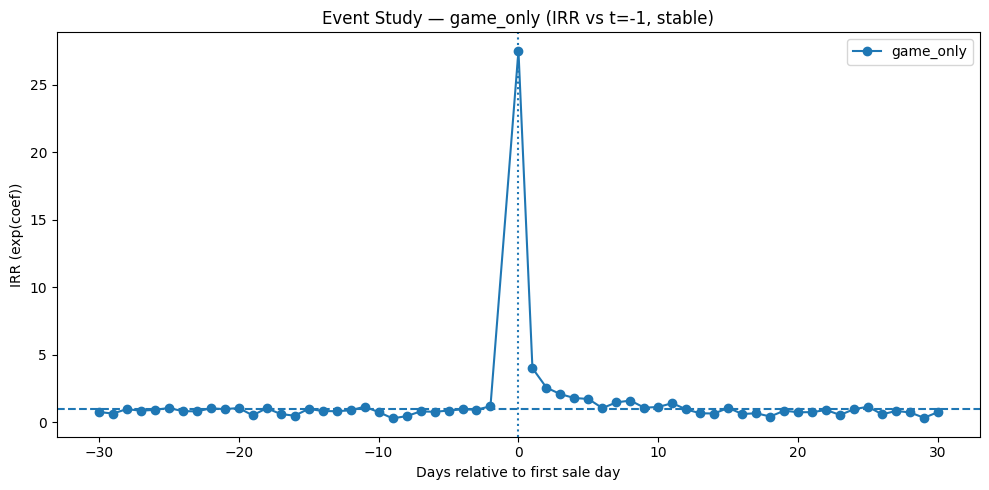

[INFO] 'both' winsorize @ 0.990: cap=2
[INFO] 'both' drop top days >0.999 (thr=5): removed 11 rows, 1 days


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.endog-mu)


[WARN] 'both' cluster SE 실패 → HC1: NaN, inf or invalid value detected in weights, estimation infeasible.


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.endog-mu)


[WARN] 'both' HC1 실패 → ridge: NaN, inf or invalid value detected in weights, estimation infeasible.

=== [both] TWFE NB (ridge(no SE)) — IRR vs t=-1 (stable) ===
params (ridge):
 Intercept             -3.084
C(appid)[T.1036890]    -1.03
C(appid)[T.1044720]   0.3997
C(appid)[T.107410]     1.219
C(appid)[T.108600]    0.4334
dtype: float64

IRR Table (stable):
 event_day   coef    IRR  IRR_ci_low  IRR_ci_high
       -30  0.222  1.249         NaN          NaN
       -29 -0.871  0.419         NaN          NaN
       -28  0.393  1.481         NaN          NaN
       -27  0.232  1.262         NaN          NaN
       -26  0.362  1.437         NaN          NaN
       -25  0.089  1.093         NaN          NaN
       -24 -0.497  0.609         NaN          NaN
       -23  0.185  1.203         NaN          NaN
       -22  0.214  1.239         NaN          NaN
       -21  0.128  1.136         NaN          NaN
       -20 -0.056  0.946         NaN          NaN
       -19 -0.899  0.407         NaN    

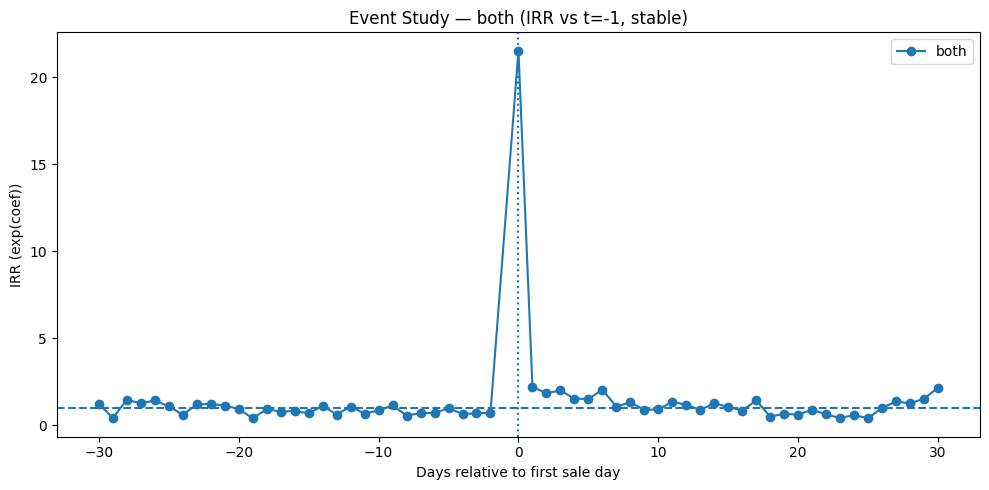

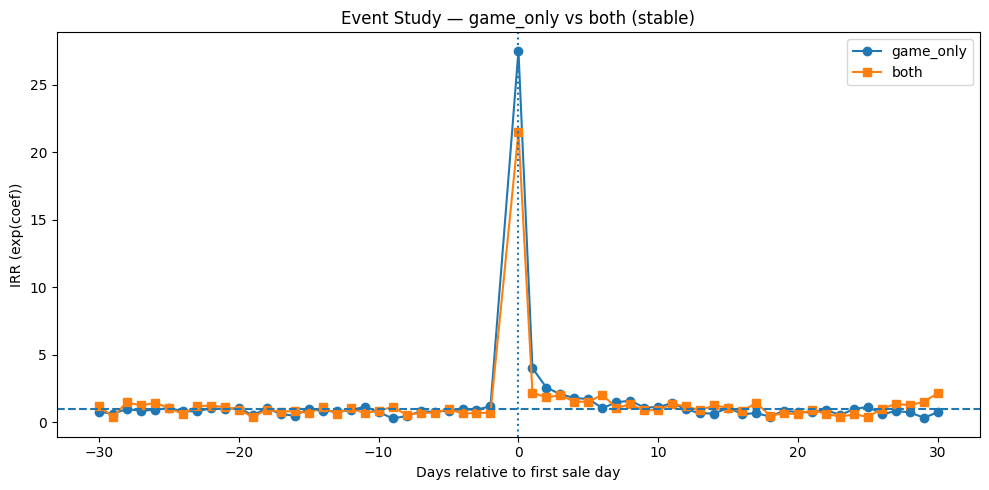

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

CSV_PATH    = "/content/S-team_250930-final.csv"
TOP_APPS    = 200            # 세일 경험 상위 게임 수
WINDOW_D    = 30             # 이벤트 윈도우(일)
USE_NB      = True           # 안정화를 위해 NB 권장(True)
SHOW_TABLE  = True

# 안정화 하이퍼파라미터 (필요시 조정)
WINSOR_Q                = 0.99   # rev_count 상단 캡 분위수
MIN_EVENT_ROWS          = 80     # 이벤트 더미가 1인 관측 최소 행수
MIN_EVENT_SUM           = 80     # 이벤트 더미 합 최소
MIN_ACTIVE_APPS_PER_DAY = 30     # 해당 event_day에 기여한 고유 app 최소
DROP_TOP_DAY_Q          = 0.999  # 컨텍스트 내 '폭발일' 제거 분위수

# 유틸 함수
def to_binary(x):
    if pd.isna(x): return np.nan
    if isinstance(x, (int, float, np.integer, np.floating)): return int(x != 0)
    s = str(x).strip().lower()
    if s in {"1","true","t","yes","y"}: return 1
    if s in {"0","false","f","no","n"}: return 0
    return np.nan

def parse_mixed_timestamp(s):
    # epoch(sec) 우선, 실패 시 ISO 문자열
    num    = pd.to_numeric(s, errors="coerce")
    dt_num = pd.to_datetime(num, unit="s", utc=True, errors="coerce")
    dt_str = pd.to_datetime(s, utc=True, errors="coerce")
    return dt_num.fillna(dt_str)

def norm_sc(x):
    if pd.isna(x): return "none"
    s = str(x).strip().lower().replace("-", "_").replace(" ", "_")
    if s in {"", "nan"}: s = "none"
    if s in {"gameonly", "only_game"}: s = "game_only"
    if s not in {"none", "game_only", "event_only", "both"}:
        s = "none"
    return s

def safe_et_name(k: int) -> str:
    return f"d_m{abs(k)}" if k < 0 else f"d_p{k}"

def parse_et_name(name: str) -> int:
    if name.startswith("d_m"): return -int(name[3:])
    if name.startswith("d_p"): return  int(name[3:])
    raise ValueError(name)

# 전처리
df = pd.read_csv(CSV_PATH, low_memory=False)

need_cols = {"appid", "timestamp_created", "on_game_sale", "sale_context"}
missing = [c for c in need_cols if c not in df.columns]
if missing:
    raise ValueError(f"필수 컬럼 누락: {missing}")

df["dt"]    = parse_mixed_timestamp(df["timestamp_created"])
df          = df.dropna(subset=["appid", "dt"]).copy()
df["appid"] = df["appid"].astype(str)
df["day"]   = pd.to_datetime(df["dt"]).dt.floor("D")

df["sale_context_norm"] = df["sale_context"].map(norm_sc)
df["on_sale"] = df["on_game_sale"].apply(to_binary).fillna(0).astype(int)

# 세일 경험 게임만 (on_sale==1 또는 sale_context in {'game_only','both'})
df["sale_flag"] = ((df["on_sale"] == 1) | (df["sale_context_norm"].isin(["game_only","both"]))).astype(int)
sale_games = df.loc[df["sale_flag"] == 1, "appid"].dropna().unique().tolist()
if not sale_games:
    raise RuntimeError("세일 경험 게임이 없습니다. sale_context/on_game_sale를 확인하세요.")

# 세일 경험 게임 중 리뷰 많은 TOP_APPS
vc = df["appid"].value_counts()
top_sale_games = vc.loc[vc.index.isin(sale_games)].head(TOP_APPS).index.tolist()
sub = df[df["appid"].isin(top_sale_games)].copy()

# appid, day 집계 + 컨텍스트 플래그
# rev_count: 그 날 해당 게임 리뷰 수
cnt_by_day  = sub.groupby(["appid","day"]).size().rename("rev_count").reset_index()

# 컨텍스트별 당일 세일 존재 여부(OR)
go_day = (sub.assign(go_flag=(sub["sale_context_norm"]=="game_only").astype(int))
              .groupby(["appid","day"])["go_flag"].max().rename("game_only_day").reset_index())
bo_day = (sub.assign(bo_flag=(sub["sale_context_norm"]=="both").astype(int))
              .groupby(["appid","day"])["bo_flag"].max().rename("both_day").reset_index())

panel0 = (cnt_by_day.merge(go_day, on=["appid","day"], how="left")
                     .merge(bo_day, on=["appid","day"], how="left")
                     .fillna({"game_only_day":0, "both_day":0}))
panel0["rev_count"]     = panel0["rev_count"].astype(int)
panel0["game_only_day"] = panel0["game_only_day"].astype(int)
panel0["both_day"]      = panel0["both_day"].astype(int)

# 컨텍스트별 '첫 세일일' 계산
def build_first_sale(panel_in: pd.DataFrame, ctx_col: str, ctx_name: str) -> pd.DataFrame:
    fs = (panel_in.loc[panel_in[ctx_col]==1, ["appid","day"]]
            .groupby("appid", as_index=False)["day"].min()
            .rename(columns={"day":"first_sale_day"}))
    fs["sale_type"] = ctx_name
    return fs

fs_go = build_first_sale(panel0, "game_only_day", "game_only")
fs_bo = build_first_sale(panel0, "both_day",      "both")
first_sale_ctx = pd.concat([fs_go, fs_bo], ignore_index=True)

panel_ctx = panel0.merge(first_sale_ctx, on="appid", how="inner")
print("[INFO] 컨텍스트별 세일 경험 게임 수:",
      panel_ctx[["appid","sale_type"]].drop_duplicates().groupby("sale_type").size().to_dict())

# 컨텍스트별 Event Study 함수
def run_event_study_for_context_stable(panel_in: pd.DataFrame, sale_type: str,
                                       WINDOW_D: int = 30,
                                       USE_NB: bool = True,
                                       WINSOR_Q: float = 0.99,
                                       MIN_EVENT_ROWS: int = 80,
                                       MIN_EVENT_SUM: int = 80,
                                       MIN_ACTIVE_APPS_PER_DAY: int = 30,
                                       DROP_TOP_DAY_Q: float = 0.999):
    """
    panel_in: columns = [appid, day, first_sale_day, rev_count, sale_type]
    """
    # treated 목록
    treated = (panel_in.loc[panel_in["sale_type"]==sale_type, ["appid","first_sale_day"]]
                      .dropna()
                      .drop_duplicates())
    if treated.empty:
        print(f"[WARN] '{sale_type}' 컨텍스트 분석 대상 없음 → skip")
        return None, None

    # 균등 패널 (±WINDOW_D)
    grids = []
    for app, fs in treated.itertuples(index=False):
        days = pd.date_range(fs - pd.Timedelta(days=WINDOW_D), fs + pd.Timedelta(days=WINDOW_D), freq="D")
        grids.append(pd.DataFrame({"appid": app, "day": days, "first_sale_day": fs}))
    grid = pd.concat(grids, ignore_index=True)

    # 매칭 + event_time
    p2 = grid.merge(panel_in.loc[panel_in["sale_type"]==sale_type,
                                 ["appid","day","first_sale_day","rev_count"]],
                    on=["appid","day","first_sale_day"], how="left")
    p2["rev_count"]  = pd.to_numeric(p2["rev_count"], errors="coerce").fillna(0).astype(int)
    p2["event_time"] = (p2["day"] - p2["first_sale_day"]).dt.days

    # Winsorize
    q_hi = (p2["rev_count"].quantile(WINSOR_Q) if p2["rev_count"].max()>0 else 0)
    if q_hi >= 1:
        p2["rev_count"] = np.minimum(p2["rev_count"], int(q_hi))
        print(f"[INFO] '{sale_type}' winsorize @ {WINSOR_Q:.3f}: cap={int(q_hi)}")

    # 폭발일(day) 제거
    day_sum = (p2.groupby("day", as_index=False)["rev_count"].sum()
                 .rename(columns={"rev_count":"rev_sum"}))
    thr = day_sum["rev_sum"].quantile(DROP_TOP_DAY_Q)
    bad_days = set(day_sum.loc[day_sum["rev_sum"]>thr, "day"])
    if bad_days:
        before = len(p2)
        p2 = p2[~p2["day"].isin(bad_days)]
        after = len(p2)
        print(f"[INFO] '{sale_type}' drop top days >{DROP_TOP_DAY_Q:.3f} (thr={thr:.0f}): removed {before-after} rows, {len(bad_days)} days")

    # 이벤트 더미(t=-1 기준)
    base_k = -1
    et_cols = []
    for k in range(-WINDOW_D, WINDOW_D+1):
        if k == base_k:
            continue
        col = safe_et_name(k)
        p2[col] = (p2["event_time"] == k).astype(int)
        et_cols.append(col)

    # 시간 FE: 주차
    p2["week_key"] = p2["day"].dt.to_period("W").astype(str)

    # event_day별 기여 게임 수로 희소 일 제거 + 최소 행수/합 조건
    et_active = []
    for c in et_cols:
        sub_napps = p2.loc[p2[c]==1, "appid"].nunique()
        if sub_napps >= MIN_ACTIVE_APPS_PER_DAY:
            et_active.append(c)
    et_active2 = []
    for c in et_active:
        if (p2[c].sum() >= MIN_EVENT_SUM) and (p2[c].count() >= MIN_EVENT_ROWS):
            et_active2.append(c)
    et_active = et_active2
    if not et_active:
        print(f"[WARN] '{sale_type}': 유효 이벤트 더미 없음 (필터 과도) → 임계값 조정 필요")
        return None, None

    # 모델 데이터프레임
    model_cols = ["rev_count", "appid", "week_key"] + et_active
    mdf = p2[model_cols].copy().replace([np.inf, -np.inf], np.nan).dropna()
    mdf["appid"]    = mdf["appid"].astype(str)
    mdf["week_key"] = mdf["week_key"].astype(str)

    # GLM: NB/Poisson + C(appid)+C(week_key)
    family = sm.families.NegativeBinomial() if USE_NB else sm.families.Poisson()
    rhs = " + ".join(et_active) + " + C(appid) + C(week_key)"
    formula = f"rev_count ~ {rhs}"

    try:
        fit = smf.glm(formula=formula, data=mdf, family=family)\
                 .fit(cov_type="cluster", cov_kwds={"groups": mdf["appid"]}, maxiter=200)
        cov_desc = "clustered by appid"
    except Exception as e1:
        print(f"[WARN] '{sale_type}' cluster SE 실패 → HC1: {e1}")
        try:
            fit = smf.glm(formula=formula, data=mdf, family=family).fit(cov_type="HC1", maxiter=200)
            cov_desc = "robust HC1"
        except Exception as e2:
            print(f"[WARN] '{sale_type}' HC1 실패 → ridge: {e2}")
            fit = sm.GLM.from_formula(formula, data=mdf, family=family)\
                        .fit_regularized(alpha=1e-4, L1_wt=0.0, maxiter=1000)
            cov_desc = "ridge(no SE)"

    # IRR & (가능 시) CI
    coef = fit.params[et_active]
    has_se = hasattr(fit, "bse") and (fit.bse is not None) and not isinstance(fit.bse, (int, float))
    if has_se:
        se   = fit.bse[et_active]
        ci_l = np.exp(coef - 1.96*se)
        ci_u = np.exp(coef + 1.96*se)
    else:
        ci_l = pd.Series([np.nan]*len(et_active), index=et_active)
        ci_u = pd.Series([np.nan]*len(et_active), index=et_active)
    irr = np.exp(coef)

    ev = (pd.DataFrame({
            "event_day": [parse_et_name(c) for c in et_active],
            "coef": coef.values,
            "IRR": irr.values,
            "IRR_ci_low": ci_l.values,
            "IRR_ci_high": ci_u.values
        }).sort_values("event_day"))

    # 출력 & 플롯
    print(f"\n=== [{sale_type}] TWFE {'NB' if USE_NB else 'Poisson'} ({cov_desc}) — IRR vs t=-1 (stable) ===")
    try:
        if SHOW_TABLE:
            print(fit.summary())
    except Exception:
        print("params (ridge):\n", fit.params.head())

    if SHOW_TABLE:
        print("\nIRR Table (stable):")
        print(ev.to_string(index=False, float_format=lambda x: f"{x:,.3f}"))

    plt.figure(figsize=(10,5))
    plt.plot(ev["event_day"], ev["IRR"], marker="o", label=f"{sale_type}")
    if has_se:
        plt.fill_between(ev["event_day"], ev["IRR_ci_low"], ev["IRR_ci_high"], alpha=0.2)
    plt.axhline(1.0, linestyle="--"); plt.axvline(0, linestyle=":")
    plt.title(f"Event Study — {sale_type} (IRR vs t=-1, stable)")
    plt.xlabel("Days relative to first sale day"); plt.ylabel("IRR (exp(coef))")
    plt.legend(); plt.tight_layout(); plt.show()

    return fit, ev

# 실행 (컨텍스트별)
fit_go, ev_go = run_event_study_for_context_stable(
    panel_ctx, "game_only",
    WINDOW_D=WINDOW_D, USE_NB=USE_NB,
    WINSOR_Q=WINSOR_Q,
    MIN_EVENT_ROWS=MIN_EVENT_ROWS, MIN_EVENT_SUM=MIN_EVENT_SUM,
    MIN_ACTIVE_APPS_PER_DAY=MIN_ACTIVE_APPS_PER_DAY,
    DROP_TOP_DAY_Q=DROP_TOP_DAY_Q
)

fit_bo, ev_bo = run_event_study_for_context_stable(
    panel_ctx, "both",
    WINDOW_D=WINDOW_D, USE_NB=USE_NB,
    WINSOR_Q=WINSOR_Q,
    MIN_EVENT_ROWS=MIN_EVENT_ROWS, MIN_EVENT_SUM=MIN_EVENT_SUM,
    MIN_ACTIVE_APPS_PER_DAY=MIN_ACTIVE_APPS_PER_DAY,
    DROP_TOP_DAY_Q=DROP_TOP_DAY_Q
)

# 두 곡선 한 그림에 비교
if (ev_go is not None) and (ev_bo is not None):
    plt.figure(figsize=(10,5))
    plt.plot(ev_go["event_day"], ev_go["IRR"], marker="o", label="game_only")
    plt.plot(ev_bo["event_day"], ev_bo["IRR"], marker="s", label="both")
    plt.axhline(1.0, linestyle="--"); plt.axvline(0, linestyle=":")
    plt.title("Event Study — game_only vs both (stable)")
    plt.xlabel("Days relative to first sale day"); plt.ylabel("IRR (exp(coef))")
    plt.legend(); plt.tight_layout(); plt.show()


###EDA해석

**1. game_only (단독 세일) 결과**

- t=0 (첫 세일일): IRR ≈ 27.5 → 전날 대비 리뷰량이 약 27배 증가.

- t=1~5: 빠르게 하락, 그래도 IRR 2~4배 수준.

- t=7 이후: 대부분 1 근처로 돌아가며, 효과 소멸.

- 해석: 단독 세일은 첫날 폭발적인 리뷰 증가를 유발하나, 효과는 짧게 지속.

**2. both (이벤트+게임 동시 세일) 결과**

- t=0: IRR ≈ 21.5 → 전날 대비 리뷰량이 약 21배 증가.

- t=1~6: 리뷰량은 1.5~2배 수준으로 유지 → game_only보다 조금 더 완만하게 감소.

- t=7 이후: 1 근처로 회귀, 일부 날은 1 미만(효과 없음 또는 역효과).

- 해석: 이벤트 동반 세일은 단독 세일보다는 첫날 효과가 약하지만 → 잔향 효과가 조금 더 길게 지속됨.

**3. 비교 (세 번째 그래프)**

- 공통점: 두 컨텍스트 모두 첫 세일일에 폭발적 리뷰량 증가.

- 차이점:

    - game_only: 첫날 효과 극대화(27배) → 이후 급격한 감소.

    - both: 첫날 효과는 다소 작음(21배) → 대신 첫 주까지는 상대적으로 완만한 감소.

**4. 인사이트:**

    - 단독 세일은 “단기 집중 효과”

    - 이벤트 동반 세일은 “중기적 잔향 효과”

###통계적 검정

In [ ]:
# =========================================================
# Event Study 상호작용 검정 전용 (game_only vs both)
# - rev_count ~ Σ_k d_k + Σ_k d_k:sale_type + C(appid)+C(week)
# - NB(GLM) cluster→HC1 폴백 / winsorize / 폭발일 제거 / 희소 이벤트 필터
# - 출력: k별 차이(Δlog-IRR), p, FDR, IRR_ratio=exp(Δ)
# - 공동 Wald: pre(k<0), post(k>=0), all(k 전체)
# =========================================================
import os, numpy as np, pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from statsmodels.stats.multitest import multipletests

# ---------- 경로 ----------
CSV_PATHS = [
    "/content/S-team_250929.csv"
]
CSV_PATH = next((p for p in CSV_PATHS if os.path.exists(p)), CSV_PATHS[0])

# ---------- 유틸 ----------
def to_binary(x):
    if pd.isna(x): return np.nan
    if isinstance(x, (int, float, np.integer, np.floating)): return int(x != 0)
    s = str(x).strip().lower()
    if s in {"1","true","t","yes","y"}: return 1
    if s in {"0","false","f","no","n"}:   return 0
    return np.nan

def parse_mixed_timestamp(s):
    num    = pd.to_numeric(s, errors="coerce")
    dt_num = pd.to_datetime(num, unit="s", utc=True, errors="coerce")
    dt_str = pd.to_datetime(s, utc=True, errors="coerce")
    return dt_num.fillna(dt_str)

def norm_sc(x):
    if pd.isna(x): return "none"
    s = str(x).strip().lower().replace("-", "_").replace(" ", "_")
    if s in {"", "nan"}: s = "none"
    if s in {"gameonly","only_game"}: s = "game_only"
    if s not in {"none","game_only","event_only","both"}: s = "none"
    return s

def safe_et_name(k:int)->str: return f"d_m{abs(k)}" if k<0 else f"d_p{k}"
def parse_et_name(name:str)->int:
    if name.startswith("d_m"): return -int(name[3:])
    if name.startswith("d_p"): return  int(name[3:])
    raise ValueError(name)

# ---------- 상호작용 검정 ----------
def run_event_interaction_tests(
    WINDOW_D=30,
    USE_NB=True,
    WINSOR_Q=0.99,
    MIN_EVENT_ROWS=80,
    MIN_EVENT_SUM=80,
    MIN_ACTIVE_APPS_PER_DAY=30,
    DROP_TOP_DAY_Q=0.999,
    TOP_APPS=200
):
    # ----- 데이터 로드 & 전처리 -----
    df = pd.read_csv(CSV_PATH, low_memory=False)
    need = {"appid","timestamp_created","on_game_sale","sale_context"}
    assert need.issubset(df.columns), f"missing: {need - set(df.columns)}"

    df["dt"]    = parse_mixed_timestamp(df["timestamp_created"])
    df          = df.dropna(subset=["appid","dt"]).copy()
    df["appid"] = df["appid"].astype(str)
    df["day"]   = pd.to_datetime(df["dt"]).dt.floor("D")

    df["sale_context_norm"] = df["sale_context"].map(norm_sc)
    df["on_sale"] = df["on_game_sale"].apply(to_binary).fillna(0).astype(int)
    df["sale_flag"] = ((df["on_sale"]==1) | (df["sale_context_norm"].isin(["game_only","both"]))).astype(int)

    sale_apps = df.loc[df["sale_flag"]==1, "appid"].unique().tolist()
    vc = df["appid"].value_counts()
    top_apps = vc.loc[vc.index.isin(sale_apps)].head(TOP_APPS).index.tolist()
    sub = df[df["appid"].isin(top_apps)].copy()

    # (appid, day) 집계 + 컨텍스트 day 플래그
    cnt = sub.groupby(["appid","day"]).size().rename("rev_count").reset_index()
    go  = (sub.assign(go=(sub["sale_context_norm"]=="game_only").astype(int))
              .groupby(["appid","day"])["go"].max().rename("game_only_day").reset_index())
    bo  = (sub.assign(bo=(sub["sale_context_norm"]=="both").astype(int))
              .groupby(["appid","day"])["bo"].max().rename("both_day").reset_index())
    panel0 = (cnt.merge(go, on=["appid","day"], how="left")
                 .merge(bo, on=["appid","day"], how="left")
                 .fillna({"game_only_day":0,"both_day":0}))
    panel0["rev_count"]     = panel0["rev_count"].astype(int)
    panel0["game_only_day"] = panel0["game_only_day"].astype(int)
    panel0["both_day"]      = panel0["both_day"].astype(int)

    # 컨텍스트별 first_sale_day
    def first_sale(panel, col, name):
        fs = (panel.loc[panel[col]==1, ["appid","day"]]
                    .groupby("appid", as_index=False)["day"].min()
                    .rename(columns={"day":"first_sale_day"}))
        fs["sale_type"] = name
        return fs
    fs_go = first_sale(panel0, "game_only_day", "game_only")
    fs_bo = first_sale(panel0, "both_day",      "both")
    fs_all = pd.concat([fs_go, fs_bo], ignore_index=True)

    # 컨텍스트 부여
    panel = panel0.merge(fs_all, on="appid", how="inner")
    print("[INFO] N apps by context:",
          panel[["appid","sale_type"]].drop_duplicates().groupby("sale_type").size().to_dict())

    # 균등 패널(app×sale_type 마다 ±WINDOW_D)
    treated = panel[["appid","first_sale_day","sale_type"]].drop_duplicates()
    grids = []
    for app, fs, st in treated.itertuples(index=False):
        days = pd.date_range(fs - pd.Timedelta(days=WINDOW_D), fs + pd.Timedelta(days=WINDOW_D), freq="D")
        grids.append(pd.DataFrame({"appid": app, "day": days, "first_sale_day": fs, "sale_type": st}))
    grid = pd.concat(grids, ignore_index=True)

    p = grid.merge(panel[["appid","day","rev_count"]], on=["appid","day"], how="left")
    p["rev_count"]  = pd.to_numeric(p["rev_count"], errors="coerce").fillna(0).astype(int)
    p["event_time"] = (p["day"] - p["first_sale_day"]).dt.days

    # 안정화: winsorize + 폭발일 제거
    q_hi = p["rev_count"].quantile(WINSOR_Q) if p["rev_count"].max()>0 else 0
    if q_hi >= 1:
        p["rev_count"] = np.minimum(p["rev_count"], int(q_hi))
        print(f"[INFO] winsorize @{WINSOR_Q:.3f}: cap={int(q_hi)}")
    day_sum = p.groupby("day", as_index=False)["rev_count"].sum().rename(columns={"rev_count":"rev_sum"})
    thr = day_sum["rev_sum"].quantile(DROP_TOP_DAY_Q)
    bad_days = set(day_sum.loc[day_sum["rev_sum"]>thr, "day"])
    if bad_days:
        before=len(p); p=p[~p["day"].isin(bad_days)]; after=len(p)
        print(f"[INFO] drop top days >{DROP_TOP_DAY_Q:.3f} (thr={thr:.0f}) → removed {before-after} rows, {len(bad_days)} days")

    # 이벤트 더미(t=-1 기준)
    et_cols = []
    for k in range(-WINDOW_D, WINDOW_D+1):
        if k == -1: continue
        col = safe_et_name(k)
        p[col] = (p["event_time"]==k).astype(int)
        et_cols.append(col)

    # 주차 FE
    p["week_key"] = p["day"].dt.to_period("W").astype(str)

    # 희소 필터(두 컨텍스트 모두 충분히 관측)
    active = []
    for c in et_cols:
        ok_both = (p.loc[(p[c]==1)&(p["sale_type"]=="both"), "appid"].nunique()   >= MIN_ACTIVE_APPS_PER_DAY)
        ok_go   = (p.loc[(p[c]==1)&(p["sale_type"]=="game_only"), "appid"].nunique() >= MIN_ACTIVE_APPS_PER_DAY)
        if ok_both and ok_go and (p[c].sum()>=MIN_EVENT_SUM) and (p[c].count()>=MIN_EVENT_ROWS):
            active.append(c)
    et_cols = active
    if not et_cols:
        raise RuntimeError("No active event dummies after filters — relax thresholds.")

    # 카테고리형(베이스: game_only)
    p["sale_type"] = pd.Categorical(p["sale_type"], categories=["game_only","both"], ordered=True)

    # ----- 모델 적합 -----
    rhs_main = " + ".join(et_cols)                            # Σ d_k
    rhs_int  = " + ".join([f"{c}:sale_type" for c in et_cols])# Σ d_k × sale_type
    formula  = f"rev_count ~ {rhs_main} + {rhs_int} + C(appid) + C(week_key)"
    family   = sm.families.NegativeBinomial() if USE_NB else sm.families.Poisson()

    try:
        fit = smf.glm(formula=formula, data=p, family=family)\
                 .fit(cov_type="cluster", cov_kwds={"groups": p["appid"]}, maxiter=200)
        cov_desc = "clustered by appid"
    except Exception as e1:
        print(f"[WARN] cluster SE failed → HC1: {e1}")
        fit = smf.glm(formula=formula, data=p, family=family).fit(cov_type="HC1", maxiter=200)
        cov_desc = "robust HC1"

    print(f"\n=== Interaction TWFE ({'NB' if USE_NB else 'Poisson'}, {cov_desc}) ===")
    print(fit.summary())

    # ----- k별 차이( both vs game_only ) 표 -----
    rows=[]
    for c in et_cols:
        name = f"{c}:sale_type[T.both]"
        if name in fit.params.index:
            beta = fit.params[name]; se = fit.bse[name]
            z = beta / se
            pval = 2*(1-norm.cdf(abs(z)))
            rows.append({
                "event_day": parse_et_name(c),
                "Delta_logIRR": beta,
                "SE": se,
                "z": z,
                "p": pval,
                "IRR_ratio (both/game_only)": np.exp(beta)
            })
    diff = pd.DataFrame(rows).sort_values("event_day")
    if not diff.empty:
        _, p_fdr, _, _ = multipletests(diff["p"].values, method="fdr_bh")
        diff["p_fdr"] = p_fdr

    print("\n=== Difference by event_day (both vs game_only) — with FDR ===")
    pd.set_option("display.float_format", lambda x: f"{x:,.4g}")
    print(diff.to_string(index=False))

    # ----- 공동 Wald: pre / post / all -----
    def wald_block(terms, label):
        if not terms: return
        R = np.zeros((len(terms), len(fit.params)))
        idx = {n:i for i,n in enumerate(fit.params.index)}
        r=0
        for t in terms:
            if t in idx:
                R[r, idx[t]] = 1.0; r+=1
        if r>0:
            res = fit.wald_test(R[:r,:])
            print(f"\n=== Joint Wald: {label} ===")
            print(res)

    post_terms = [f"{c}:sale_type[T.both]" for c in et_cols if parse_et_name(c) >= 0]
    pre_terms  = [f"{c}:sale_type[T.both]" for c in et_cols if parse_et_name(c) <  0]
    wald_block(pre_terms,  "pre (k<0) differences = 0")
    wald_block(post_terms, "post (k≥0) differences = 0")
    wald_block([f"{c}:sale_type[T.both]" for c in et_cols], "ALL k interaction = 0")

# ---------- 실행 ----------
if __name__ == "__main__":
    run_event_interaction_tests(
        WINDOW_D=30,
        USE_NB=True,          # 실패 시 False로 바꿔 Poisson 시도
        WINSOR_Q=0.99,
        MIN_EVENT_ROWS=80,
        MIN_EVENT_SUM=80,
        MIN_ACTIVE_APPS_PER_DAY=30,
        DROP_TOP_DAY_Q=0.999,
        TOP_APPS=200
    )


[INFO] N apps by context: {'both': 117, 'game_only': 125}
[INFO] winsorize @0.990: cap=2
[INFO] drop top days >0.999 (thr=18) → removed 25 rows, 1 days


/tmp/ipython-input-27384489.py:142: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  p["week_key"] = p["day"].dt.to_period("W").astype(str)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "



=== Interaction TWFE (NB, clustered by appid) ===
                 Generalized Linear Model Regression Results                  
Dep. Variable:              rev_count   No. Observations:                15325
Model:                            GLM   Df Residuals:                    14756
Model Family:        NegativeBinomial   Df Model:                          568
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4573.7
Date:                Tue, 30 Sep 2025   Deviance:                       3963.3
Time:                        02:15:09   Pearson chi2:                 8.60e+03
No. Iterations:                    24   Pseudo R-squ. (CS):             0.1969
Covariance Type:              cluster                                         
                                           coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:1912: FutureWarning: The behavior of wald_test will change after 0.14 to returning scalar test statistic values. To get the future behavior now, set scalar to True. To silence this message while retaining the legacy behavior, set scalar to False.
  warnings.warn(


###통계적 검정 해석

**1. 개별 event-day 차이 (both vs game_only)**

- Delta_logIRR: 두 세일 타입의 로그-발생률비(log IRR) 차이

- 양수이면 both 세일이 game_only보다 리뷰량이 더 많다, 음수이면 적다.

- d_p0:sale_type[T.both] = -0.339 (p=0.024)

    → 세일 당일(0일)에 both 세일의 리뷰량은 game_only 대비 약 0.71배 수준으로 유의하게 낮음.

- d_p1:sale_type[T.both] = -0.602 (p=0.006)
    → 세일 다음날에도 both가 **절반 수준(0.55배)**으로 낮음.

- d_p29, d_p30 같은 후행 구간에서 일시적으로 both > game_only라는 신호가 있지만, FDR 보정 후(p_fdr) 다수는 유의성이 사라짐.

👉 요약: 이벤트 직후(특히 0~1일)에 both 세일은 game_only보다 리뷰량이 더 낮게 나타났고, 일부 후행 구간에서 반등 신호가 보이나 다중비교 보정 후 확정적이진 않음.

**2. 공동 Wald 검정 (pre vs post vs 전체)**

- pre (k<0): p=0.384

    → 세일 이전 두 그룹(both vs game_only) 간 차이는 없음.

    → 즉, 세일 시작 전엔 두 그룹의 리뷰 추세가 비슷했다는 의미 : 사전 평행추세 가정이 대체로 성립.

- post (k≥0): p=0.002

    → 세일 이후 두 그룹 간 차이는 유의하게 존재.

    → 즉, 세일 이벤트 이후 both vs game_only의 리뷰 패턴은 확연히 달라짐.

- ALL k: p≈7.6e-16

    → 전체 기간(전후 포함)에서 두 그룹의 리뷰 추이는 유의하게 다름.

**3. 전반적 해석**

- 세일 전에는 both vs game_only 차이 없음 → 비교 적절.

- 세일 후에는 both 세일이 game_only보다 리뷰량 반응이 약하거나 늦게 나타남.

- 즉, **이벤트+게임 동시 세일(both)**은 단기적으로 오히려 리뷰 폭증 효과가 작고, game_only가 더 강한 반응을 보임.

- 장기적으로는 일부 구간에서 both가 더 많아지는 신호도 있으나, 다중보정 후 확정적이지 않음.

**4. 최종 요약**

게임 단독 세일은 이벤트+게임 동시 세일보다 세일 직후 리뷰량 상승 효과가 더 강하며, 사전 추세는 유사했지만 사후 반응에서 두 그룹 간 유의한 차이가 발생했다.